# Equivariant Neural Field (ENF) Training

This notebook implements training for an Equivariant Neural Field model. ENFs are a type of neural field that respects certain symmetries in the data, making them particularly effective for image representation tasks.

## Imports and Environment Setup

In [1]:
import os 
import math
import logging
from pathlib import Path

import ml_collections
import jax
import jax.numpy as jnp
import optax
import orbax.checkpoint as ocp
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
import torchvision
import torch.utils.data as data

import jax
import jax.numpy as jnp
from flax import linen as nn

from typing import Callable, Union, Any, Sequence, Tuple, Optional

# Set environment to use GPU
os.environ['JAX_PLATFORM_NAME'] = 'gpu'

## Configuration

Define the configuration for the model, dataset, and training parameters.

In [2]:
# Define config
config = ml_collections.ConfigDict()
config.seed = 68
config.debug = False

# Define the ENF model parameters
config.enf = ml_collections.ConfigDict()
config.enf.num_in = 2           # Images are 2D
config.enf.num_out = 3          # RGB images = 3 channels, grayscale = 1
config.enf.num_hidden = 64
config.enf.num_heads = 3
config.enf.att_dim = 64
config.enf.num_latents = 16
config.enf.latent_dim = 32
config.enf.emb_freq = (1.0, 2.0)   # (query, value)
config.enf.k_nearest = 4
config.enf.bi_invariant = "translation"  # Choose between translation and roto_translation_2d

# Dataset config
config.dataset = ml_collections.ConfigDict()
config.dataset.path = "./data"
config.dataset.name = "cifar10"           # Choose between cifar10 and FIGURE
config.dataset.num_signals_train = 50000   # Change this to 10000 for the full dataset !!! !!! !!! !!! !!! !!! !!! !!! !!! !!!
config.dataset.num_signals_test = 10000
config.dataset.batch_size = 32
config.dataset.num_workers = 8

# Specific FIGURE dataset parameters
config.dataset.figure_type = "FIGURE-Shape-B"  # Choose between FIGURE-Shape-B and FIGURE-Shape-CB
config.dataset.swap_bias = False               # Mainly interesting for down-stream tasks
config.dataset.color_consistency = 0.9

# Optimizer config
config.optim = ml_collections.ConfigDict()
config.optim.lr_enf = 5e-4
config.optim.inner_lr = (1.0, 15.0, 0.0)    # (poses, context, gaussian window)
config.optim.inner_steps = 3

NameError: name 'ml_collections' is not defined

# Some utility functions

In [3]:
def numpy_collate(batch: list[np.ndarray]) -> np.ndarray:
    """
    This function acts as replacement to the standard PyTorch-tensor collate function in PyTorch DataLoader.

    Args:
        batch: Batch of data. Can be a numpy array, a list of numpy arrays, or nested lists of numpy arrays.

    Returns:
        Batch of data as (potential list or tuple of) numpy array(s).
    """
    if isinstance(batch, np.ndarray):
        return batch
    elif isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)
    

def get_dataset(dataset_cfg):
    """ Function which gets the dataset based on the dataset config. For now it only supports CIFAR10 and the FIGURE dataset."""

    if dataset_cfg.name == "cifar10":
        transform = torchvision.transforms.Compose([lambda x: np.array(x)/255])
        train_dset = torchvision.datasets.CIFAR10(root=dataset_cfg.path, train=1, transform=transform, download=1)
        test_dset = torchvision.datasets.CIFAR10(root=dataset_cfg.path, train=0, transform=transform, download=1)
    elif dataset_cfg.name == "FIGURE":
        from datasets.figure_dset import FigureDataset

        transform = torchvision.transforms.Compose([lambda x: x.numpy(), lambda x: x.transpose(1, 2, 0)])
        train_dset = FigureDataset("FIGURE-Shape-B", split="train", color_consistency=0.9, transform=transform, download=True)  

        if dataset_cfg.swap_bias:
            test_dset = FigureDataset("FIGURE-Shape-CB", split="test-bias", color_consistency=0.9, transform=transform, download=True)
        else:
            test_dset = FigureDataset("FIGURE-Shape-B", split="test", color_consistency=0.9, transform=transform, download=True)
    else:
        raise ValueError(f"Unknown dataset name: {dataset_cfg.name}")
    
    return train_dset, test_dset


def get_dataloader(dataset_cfg, shuffle_train=True):
    """ Function which gets the dataloader based on the dataset config. """

    train_dset, test_dset = get_dataset(dataset_cfg)
    
    if dataset_cfg.num_signals_train != -1:
        train_dset = data.Subset(train_dset, np.arange(0, dataset_cfg.num_signals_train))
    if dataset_cfg.num_signals_test != -1:
        test_dset = data.Subset(test_dset, np.arange(0, dataset_cfg.num_signals_test))

    train_loader = data.DataLoader(
        train_dset,
        batch_size=dataset_cfg.batch_size,
        shuffle=shuffle_train,
        num_workers=dataset_cfg.num_workers,
        collate_fn=numpy_collate,
        persistent_workers=False,
        drop_last=True
    )

    test_loader = data.DataLoader(
        test_dset,
        batch_size=dataset_cfg.batch_size,
        shuffle=False,
        num_workers=dataset_cfg.num_workers,
        collate_fn=numpy_collate,
        persistent_workers=False,
        drop_last=True
    )
    return train_loader, test_loader


## Model Definition
### Positional embedding

The positional embedding is a key component that transforms spatial coordinates into a higher-dimensional representation. The mathematical formula is:

1. First, scale the input coordinates: $\pi(x + 1)$
2. Project to a lower dimension with random weights: $e = W \cdot \pi(x + 1)$ where $W \sim \mathcal{N}(0, \text{freq})$
3. Apply sinusoidal encoding: $\sin([x, e, e + \pi/2])$
4. Project to final embedding dimension: $\text{PosEmb}(x) = W_{\text{out}} \cdot \sin([x, e, e + \pi/2])$

This embedding helps the model capture spatial relationships at different frequencies.

In [4]:
class PosEmb(nn.Module):
    embedding_dim: int
    freq: float

    @nn.compact
    def __call__(self, coords):
        emb = nn.Dense(self.embedding_dim // 2, kernel_init=nn.initializers.normal(self.freq), use_bias=False)(
            jnp.pi * (coords + 1))
        return nn.Dense(self.embedding_dim)(jnp.sin(jnp.concatenate([emb, emb + jnp.pi / 2.0], axis=-1)))

### Visualize the positional embedding

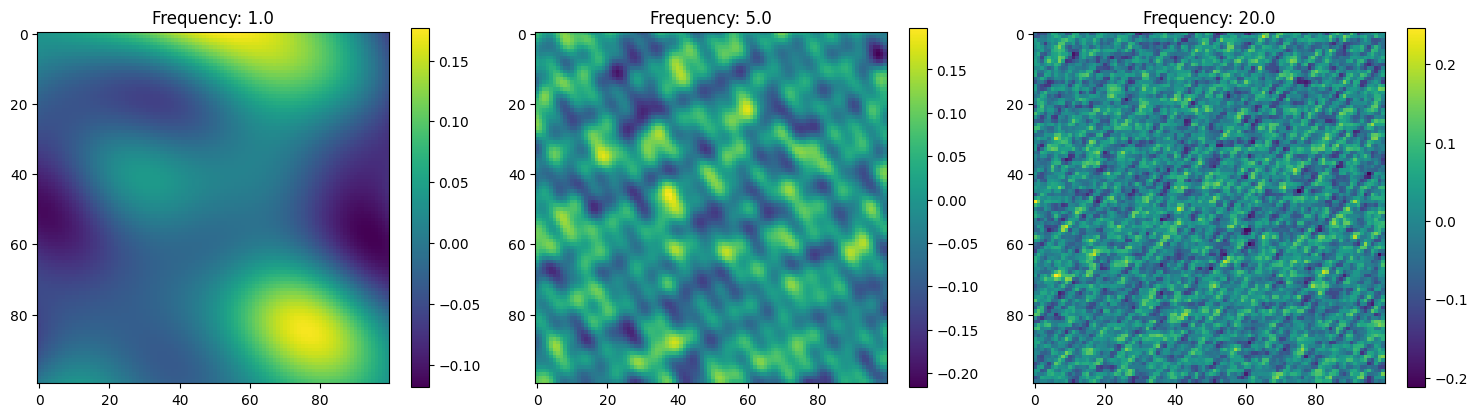

In [5]:

# Initialize the positional embedding for different frequencies
freqs = [1.0, 5.0, 20.0]
posemb = [PosEmb(128, freq) for freq in freqs]

# Create a grid of coordinates
grid = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100)), axis=-1)
grid = jnp.reshape(grid, (-1, 2))
grid = jnp.repeat(grid[None, ...], 1, axis=0)
params = [posemb[i].init(jax.random.PRNGKey(i), grid) for i in range(len(posemb))]
out = [posemb[i].apply(params[i], grid) for i in range(len(posemb))]

# Plot the output for each frequency
plt.figure(figsize=(15, 4))
for i in range(len(posemb)):
    plt.subplot(1, 3, i+1)
    plt.imshow(jnp.mean(out[i][0].reshape(100, 100, -1), axis=-1)) # average over the embedding dimension
    plt.colorbar()
    plt.title(f"Frequency: {freqs[i]}")
plt.tight_layout()
plt.show()


## Define the bi-invariant functions

Bi-invariant functions are crucial for ensuring equivariance in neural fields. They transform input coordinates and latent poses into representations that respect certain symmetries:

1. **Translation Bi-invariant**:
   - Formula: $\text{BI}_{\text{trans}}(x, p) = x - p$
   - This creates a representation that is invariant to global translations of both input coordinates and latent poses.

2. **Roto-Translation Bi-invariant (2D)**:
   - For input coordinates $x \in \mathbb{R}^2$ and latent poses $p = (p_{\text{pos}}, \theta) \in \mathbb{R}^2 \times \mathbb{R}$:
   - First compute relative position: $\Delta x = x - p_{\text{pos}}$
   - Then rotate by $-\theta$ to get invariant representation:
     - $\text{BI}_{\text{roto-trans}}(x, p)_1 = \Delta x_1 \cos(\theta) + \Delta x_2 \sin(\theta)$
     - $\text{BI}_{\text{roto-trans}}(x, p)_2 = -\Delta x_1 \sin(\theta) + \Delta x_2 \cos(\theta)$
   - This creates a representation that is invariant to both translations and rotations.

These bi-invariants ensure that the neural field's predictions remain consistent under the corresponding transformations of the input space.

In [6]:
def get_bi_invariant(name: str):
    """ Get the bi-invariant function by name. Currently supports 'translation' and 'roto_translation_2d'"""
    
    if name == "translation":
        return TranslationBI()
    elif name == "roto_translation_2d":
        return RotoTranslationBI2D()
    else:
        raise ValueError(f"Bi-invariant {name} not found.")


class TranslationBI:   
    def __call__(self, x: jnp.ndarray, p: jnp.ndarray) -> jnp.ndarray:
        """Compute the translation equivariant bi-invariant for ND data.
        
        Args:
            x: The input data. Shape (batch_size, num_coords, coord_dim).
            p: The latent poses. Shape (batch_size, num_latents, coord_dim).
        """
        return x[:, :, None, :] - p[:, None, :, :]


class RotoTranslationBI2D:
    def __call__(self, x: jnp.ndarray, p: jnp.ndarray) -> jnp.ndarray:
        """ Compute roto-translation bi-invariant for 2D data. This assumes the input coordinates are
        2D, i.e. do not include the orientation. The latents include orientation angle theta.
        
        Args:
            x: The input data. Shape (batch_size, num_coords, pos_dim (2)).
            p: The latent poses. Shape (batch_size, num_latents, pos_dim (2) + theta (1)).
        """
        # Compute the relative position between the input and the latent poses
        rel_pos = x[:, :, None, :2] - p[:, None, :, :2]

        # Get the orientation angle theta and convert to [cos(θ), sin(θ)]
        theta = p[:, None, :, 2:]
        cos_theta = jnp.cos(theta)
        sin_theta = jnp.sin(theta)

        # Compute the relative orientation between the input and the latent poses
        invariant1 = rel_pos[..., 0] * cos_theta + rel_pos[..., 1] * sin_theta
        invariant2 = -rel_pos[..., 0] * sin_theta + rel_pos[..., 1] * cos_theta
        return jnp.stack([invariant1, invariant2], axis=-1)


### Latent Initialization

The initialization of latents is a crucial step in our Equivariant Neural Field model. The `initialize_grid_positions` and `initialize_latents` functions work together to:

1. Create a structured grid of latent positions that will serve as anchor points for the model
2. Add appropriate pose information depending on the type of bi-invariance (translation or roto-translation)

For translation-only bi-invariance:
- Creates a regular grid of positions in N-dimensional space
- Grid points are normalized to [-1, 1] range
- Number of grid points is determined by the desired number of latents
- Small random noise is added to prevent exact grid alignment

For roto-translation bi-invariance (2D):
- Creates a 2D grid of positions as above
- Additionally adds a rotation angle θ for each position
- Rotation angles are uniformly sampled from [0, 2π]

These latent positions and poses act as learnable reference points that the model uses to decompose and represent the input signal in an equivariant way.

In [7]:
def initialize_grid_positions(batch_size: int, num_latents: int, data_dim: int) -> jnp.ndarray:
    """Initialize a grid of positions in N dimensions."""
    # Calculate grid size per dimension
    grid_size = int(math.ceil(num_latents ** (1/data_dim)))
    lims = 1 - 1 / grid_size
    
    # Create linspace for each dimension
    linspaces = [jnp.linspace(-lims, lims, grid_size) for _ in range(data_dim)]
    
    # Create meshgrid
    grid = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    
    # Reshape and repeat for batch
    positions = jnp.reshape(grid, (1, -1, data_dim))
    positions = positions.repeat(batch_size, axis=0)
    
    # If we have more points than needed, truncate
    if positions.shape[1] > num_latents:
        positions = positions[:, :num_latents, :]
    
    return positions


def initialize_latents(
    batch_size: int,
    num_latents: int,
    latent_dim: int,
    data_dim: int,
    bi_invariant_cls: Any,
    key: Any,
    window_scale: float = 2.0,
    noise_scale: float = 0.1,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Initialize the latent variables based on the bi-invariant type."""
    key, subkey = jax.random.split(key)

    assert math.ceil(num_latents ** (1/data_dim)) ** data_dim == num_latents, "Number of latents must be a perfect power of the data dimension"

    if type(bi_invariant_cls) == TranslationBI:
        # For translation-only, positions are same dimension as data
        pose = initialize_grid_positions(batch_size, num_latents, data_dim)
        
        # Add some random noise to positions to prevent exact grid alignment
        pose = pose + jax.random.normal(subkey, pose.shape) * noise_scale / jnp.sqrt(num_latents)

    elif type(bi_invariant_cls) == RotoTranslationBI2D:
        if data_dim != 2:
            raise ValueError("RotoTranslationBI2D requires 2D data")
        
        # Initialize positions in 2D
        positions_2d = initialize_grid_positions(batch_size, num_latents, 2)
        
        # Add some random noise to positions to prevent exact grid alignment
        positions_2d = positions_2d + jax.random.normal(subkey, positions_2d.shape) * noise_scale / jnp.sqrt(num_latents)

        # Add orientation angle theta
        key, subkey = jax.random.split(key)
        theta = jax.random.uniform(subkey, (batch_size, num_latents, 1)) * 2 * jnp.pi
        
        # Concatenate positions and theta
        pose = jnp.concatenate([positions_2d, theta], axis=-1)
        
    else:
        raise ValueError(f"Unsupported bi-invariant type: {bi_invariant_cls}")

    # Initialize context vectors and gaussian window
    context = jnp.ones((batch_size, num_latents, latent_dim)) / latent_dim
    window = jnp.ones((batch_size, num_latents, 1)) * window_scale / jnp.sqrt(num_latents)
    
    return pose, context, window


### Equivariant Neural Field

In [8]:
class EquivariantNeuralField(nn.Module):
    """ Equivariant cross attention network for the latent points, conditioned on the poses.

    Args:
        num_hidden (int): The number of hidden units.
        num_heads (int): The number of attention heads.
        num_out (int): The number of output coordinates.
        emb_freq_q (float): The frequency of the positional embedding for the query.
        emb_freq_v (float): The frequency of the positional embedding for the value function.
        nearest_k (int): The number of nearest latents to consider.
        bi_invariant (Callable): The bi-invariant function to use.
    """
    num_hidden: int
    att_dim: int
    num_heads: int
    num_out: int
    emb_freq: Tuple[float, float]
    nearest_k: int
    bi_invariant: Callable

    def setup(self):
        # Positional embedding that takes in relative positions.
        self.pos_emb_q = nn.Sequential([PosEmb(self.num_hidden, self.emb_freq[0]), nn.Dense(self.num_heads * self.att_dim)])
        self.pos_emb_v = nn.Sequential([PosEmb(self.num_hidden, self.emb_freq[1]), nn.Dense(2 * self.num_hidden)])

        # Query, key, value functions.
        self.W_k = nn.Dense(self.num_heads * self.att_dim)
        self.W_v = nn.Dense(self.num_hidden)

        # Value bi-linear conditioning function.
        self.v = nn.Sequential([
            nn.Dense(self.num_hidden),
            nn.gelu,
            nn.Dense(self.num_heads * self.num_hidden)])

        # Output layer.
        self.W_out = nn.Dense(self.num_out)

    def __call__(self, x, p, c, g):
        """ Apply equivariant cross attention.

        Args:
            x (jax.numpy.ndarray): The input coordinates. Shape (batch_size, num_coords, coord_dim).
            p (jax.numpy.ndarray): The latent poses. Shape (batch_size, num_latents, coord_dim).
            c (jax.numpy.ndarray): The latent context vectors. Shape (batch_size, num_latents, latent_dim).
            g (jax.numpy.ndarray): The window size for the gaussian window. Shape (batch_size, num_latents, 1).
        """
        # Calculate bi-invariants between input coordinates and latents
        #   bi_inv: (batch_size, num_coords, num_latents, coord_dim)
        bi_inv = self.bi_invariant(x, p)
        
        # Calculate distances based on bi-invariant magnitude
        #   zx_mag: (batch_size, num_coords, num_latents)
        zx_mag = jnp.sum(bi_inv ** 2, axis=-1)
        
        # Get the indices of the nearest latents
        #   nearest_z: (batch_size, num_coords, num_latents, nearest_k)
        nearest_z = jnp.argsort(zx_mag, axis=-1)[:, :, :self.nearest_k, None]

        # Restrict the bi-invariants and context vectors to the nearest latents
        zx_mag = jnp.take_along_axis(zx_mag[..., None], nearest_z, axis=2)
        bi_inv = jnp.take_along_axis(bi_inv, nearest_z, axis=2)
        k = jnp.take_along_axis(self.W_k(c)[:, None, :, :], nearest_z, axis=2)
        v = jnp.take_along_axis(self.W_v(c)[:, None, :, :], nearest_z, axis=2)
        g = jnp.take_along_axis(g[:, None, :, :], nearest_z, axis=2)

        # Apply bi-invariant embedding for the query transform and conditioning of the value transform
        #   q: (batch_size, num_coords, num_latents, num_heads * att_dim)
        q = self.pos_emb_q(bi_inv)
        
        # Split the value embedding into bias and gaussian window
        #   b_v: (batch_size, num_coords, num_latents, num_hidden)
        #   g_v: (batch_size, num_coords, num_latents, 1)
        b_v, g_v = jnp.split(self.pos_emb_v(bi_inv), 2, axis=-1)
        
        # Apply the value bi-linear conditioning function
        #   v: (batch_size, num_coords, num_latents, num_heads * num_hidden)
        v = self.v(v * (1 + b_v) + g_v)

        # Reshape to separate the heads
        #   q: (batch_size, num_coords, num_latents, num_heads, att_dim)
        #   k: (batch_size, num_coords, num_latents, num_heads, att_dim)
        #   v: (batch_size, num_coords, num_latents, num_heads, num_hidden)
        q = q.reshape(q.shape[:-1] + (self.num_heads, -1))
        k = k.reshape(k.shape[:-1] + (self.num_heads, -1))
        v = v.reshape(v.shape[:-1] + (self.num_heads, -1))

        # Calculate the attention weights, apply gaussian mask based on bi-invariant magnitude, broadcasting over heads.
        #   att_logits: (batch_size, num_coords, num_latents, num_heads)
        att_logits = ((q * k).sum(axis=-1, keepdims=True) / self.att_dim) - ((1 / g ** 2) * zx_mag)[..., None, :]
        att = jax.nn.softmax(att_logits, axis=2)

        # Attend the values to the queries and keys.
        #   y: (batch_size, num_coords, num_latents, num_heads, num_hidden)
        y = (att * v).sum(axis=2)

        # Combine the heads and apply the output layer.
        #   y: (batch_size, num_coords, num_latents, num_heads * num_hidden)
        y = y.reshape(y.shape[:-2] + (-1,))
        return self.W_out(y)


## Dataset

In [9]:
# Load dataset, get sample image, create corresponding coordinates
train_dloader, test_dloader = get_dataloader(config.dataset)
sample = next(iter(train_dloader))
img_shape = sample[0].shape[1:]

# Random key for JAX operations
key = jax.random.PRNGKey(55)

# Create coordinate grid
x = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, img_shape[0]), jnp.linspace(-1, 1, img_shape[1])), axis=-1)
x = jnp.reshape(x, (-1, 2))
x = jnp.repeat(x[None, ...], config.dataset.batch_size, axis=0)

# Define the model
bi_inv = get_bi_invariant(config.enf.bi_invariant)
model = EquivariantNeuralField(
    num_hidden=config.enf.num_hidden,
    att_dim=config.enf.att_dim,
    num_heads=config.enf.num_heads,
    num_out=config.enf.num_out,
    emb_freq=config.enf.emb_freq,
    nearest_k=config.enf.k_nearest,
    bi_invariant=bi_inv,
)

/gpfs/home1/rvalperga/miniforge3/envs/enf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/gpfs/home1/rvalperga/miniforge3/envs/enf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Initialize Model Parameters

In JAX, we need to initialize model parameters by passing dummy inputs through the model so it can infer parameter shapes for JIT compilation.

In [10]:
# Create dummy latents for model initialization
dummy_z = initialize_latents(
    batch_size=config.dataset.batch_size,
    num_latents=config.enf.num_latents,
    latent_dim=config.enf.latent_dim,
    data_dim=config.enf.num_in,
    bi_invariant_cls=bi_inv,
    key=key,
)
enf_params = model.init(key, x, *dummy_z)

# Define optimizer for the ENF backbone
enf_optimizer = optax.adam(learning_rate=config.optim.lr_enf)
enf_opt_state = enf_optimizer.init(enf_params)

## Define Training Functions

Define the inner loop and outer step functions for training. The inner loop optimizes the latent variables, while the outer step updates the model parameters.

In [11]:
@jax.jit
def inner_loop(enf_params, coords, img, key):
    z = initialize_latents(
        batch_size=config.dataset.batch_size,
        num_latents=config.enf.num_latents,
        latent_dim=config.enf.latent_dim,
        data_dim=config.enf.num_in,
        bi_invariant_cls=bi_inv,
        key=key,
    )

    def mse_loss(z):
        out = model.apply(enf_params, coords, *z)
        return jnp.sum(jnp.mean((out - img) ** 2, axis=(1, 2)), axis=0)

    def inner_step(z):
        # Calculate the gradient of the loss function
        _, grads = jax.value_and_grad(mse_loss)(z)
         
        # Gradient descent update
        z = jax.tree.map(lambda z, grad, lr: z - lr * grad, z, grads, config.optim.inner_lr)
        return z
    
    # Perform inner loop optimization
    for _ in range(config.optim.inner_steps):
        z = inner_step(z)

    return mse_loss(z), z

@jax.jit
def outer_step(coords, img, enf_params, enf_opt_state, key):
    # Perform inner loop optimization
    key, subkey = jax.random.split(key)
    (loss, z), grads = jax.value_and_grad(inner_loop, has_aux=True)(enf_params, coords, img, key)

    # Update the ENF backbone
    enf_grads, enf_opt_state = enf_optimizer.update(grads, enf_opt_state)
    enf_params = optax.apply_updates(enf_params, enf_grads)

    # Sample new key
    return (loss, z), enf_params, enf_opt_state, subkey

## Training Loop

Execute the training loop, periodically logging results and saving checkpoints.

In [12]:
log_figures = True # Set to False to not save figures
num_epochs =32
log_interval = 500

def plot_images(img, img_r, z, epoch, glob_step):
        
        # Min max normalization
        min_val = jnp.min(img[0])
        max_val = jnp.max(img[0])

        img_r = (img_r - jnp.min(img_r)) / (jnp.max(img_r) - jnp.min(img_r))
        img = (img - min_val) / (max_val - min_val)

        # Plot the original and reconstructed image
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.imshow(jnp.reshape(img[0], (img_shape)))
        plt.title("Original")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(jnp.reshape(img_r, (img_shape)))
        plt.title("Reconstructed")
        plt.axis('off')

        # Plot the poses
        plt.subplot(133)
        plt.imshow(jnp.reshape(img_r, (img_shape)))
        plt.title("Poses")
        plt.axis('off')

        # Poses are [-1, 1], map to [0, img_shape]
        poses_m = (z[0] + 1) / 2 * img_shape[0]
        plt.scatter(poses_m[0, :, 0], poses_m[0, :, 1], c='r')
        plt.savefig(f"figures/epoch_{epoch}_step_{glob_step}.png")
        plt.close('all')

### Training Loop

In [13]:
# Training loop
glob_step, lowest_loss = 0, jnp.inf
for epoch in range(num_epochs):
    epoch_loss = []
    with tqdm(enumerate(train_dloader), total=len(train_dloader), desc=f'Epoch {epoch}') as pbar:
        for i, batch in pbar:
            img = batch[0]
            y = jnp.reshape(img, (img.shape[0], -1, img.shape[-1]))

            # Perform outer loop optimization
            (loss, z), enf_params, enf_opt_state, key = outer_step(
                x, y, enf_params, enf_opt_state, key)

            epoch_loss.append(loss)
            glob_step += 1

            # Update progress bar with current loss
            pbar.set_postfix({"loss": float(loss)})

            if glob_step % log_interval == 0 and log_figures:
                img_r = model.apply(enf_params, x, *z)[0]
                plot_images(img, img_r, z, epoch, glob_step)



Epoch 31: 100%|██████████| 31/31 [00:00<00:00, 50.22it/s, loss=0.102] 


### Classifier

In [14]:
class MlpBlock(nn.Module):
    mlp_dim: int
    out_dim: Optional[int] = None

    @nn.compact
    def __call__(self, inputs):
        actual_out_dim = inputs.shape[-1] if self.out_dim is None else self.out_dim
        x = nn.Dense(
                features=self.mlp_dim,
                kernel_init=nn.initializers.xavier_uniform(),
                bias_init=nn.initializers.normal(stddev=1e-6))(inputs)
        x = nn.gelu(x)
        output = nn.Dense(
                features=actual_out_dim,
                kernel_init=nn.initializers.xavier_uniform(),
                bias_init=nn.initializers.normal(stddev=1e-6))(x)
        return output
    
def modulate(x, shift, scale):
    return x * (1 + scale[:, None]) + shift[:, None]

class TransformerBlock(nn.Module):
    hidden_size: int
    num_heads: int
    mlp_ratio: float = 4.0

    @nn.compact
    def __call__(self, x):
        x_norm = nn.LayerNorm(use_bias=False, use_scale=False)(x)
        attn_x = nn.MultiHeadDotProductAttention(kernel_init=nn.initializers.xavier_uniform(),
            num_heads=self.num_heads)(x_norm, x_norm)
        x = x + attn_x

        # MLP Residual.
        x_norm2 = nn.LayerNorm(use_bias=False, use_scale=False)(x)
        mlp_x = MlpBlock(mlp_dim=int(self.hidden_size * self.mlp_ratio))(x_norm2)
        x = x + mlp_x
        return x
    
class FinalLayer(nn.Module):
    out_channels: int
    hidden_size: int

    @nn.compact
    def __call__(self, x):
        x = nn.LayerNorm()(x)
        x = nn.Dense(self.out_channels, kernel_init=nn.initializers.constant(0))(x)
        return x

class TransformerClassifier(nn.Module):
    """
    Transformer model.
    """
    hidden_size: int
    depth: int
    num_heads: int
    mlp_ratio: float
    num_classes: int
    emb_freq: float = 1.0

    @nn.compact
    def __call__(self, p_0, c_0, g_0):
        # Embed patches and poses.
        pos_embed = PosEmb(self.hidden_size, freq=self.emb_freq)(p_0)
        c = nn.Dense(self.hidden_size, kernel_init=nn.initializers.xavier_uniform())(c_0)
        c = c + pos_embed

        # Run DiT blocks on input and conditioning.
        for _ in range(self.depth):
            c = TransformerBlock(self.hidden_size, self.num_heads, self.mlp_ratio)(c)

        # Final layer.
        return FinalLayer(self.num_classes, self.hidden_size)(jnp.mean(c, axis=1))


### Define Transformer Classifier

In [15]:
classifier_config = ml_collections.ConfigDict()
classifier_config.num_hidden = 768
classifier_config.depth = 12
classifier_config.num_heads = 12
classifier_config.mlp_ratio = 4
classifier_config.num_classes = 10
classifier_config.emb_freq = 1.0

classifier_config.lr_transformer = 1e-4
classifier_config.num_epochs = 32
classifier_config.log_interval = 500

transformer = TransformerClassifier(
    hidden_size=classifier_config.num_hidden,
    depth=classifier_config.depth,
    num_heads=classifier_config.num_heads,
    mlp_ratio=classifier_config.mlp_ratio,
    num_classes=classifier_config.num_classes,
    )

# Create dummy latents for model init
key, subkey = jax.random.split(key)
temp_z = initialize_latents(
    batch_size=1,  # Only need one example for initialization
    num_latents=config.enf.num_latents,
    latent_dim=config.enf.latent_dim,
    data_dim=config.enf.num_in,
    bi_invariant_cls=TranslationBI(),
    key=subkey,
)

# Define optimizer for the transformer model
transformer_opt = optax.adam(learning_rate=classifier_config.lr_transformer)
transformer_params = transformer.init(key, *temp_z)
transformer_opt_state = transformer_opt.init(transformer_params)

# Training the classifier is much faster when the context vectors are normalized.
# We determine mean and std of the context vectors and normalize them.
c_list = []
for i, (img, _) in enumerate(train_dloader):
    # Do inner loop, get latents
    y = jnp.reshape(img, (img.shape[0], -1, img.shape[-1]))
    _, z = inner_loop(enf_params, x, y, key)

    # Append context vectors to list
    c_list.append(z[1])

# Compute mean and std of the context vectors
c_mean = jnp.mean(jnp.concatenate(c_list, axis=0), axis=(0, 1))
c_std = jnp.std(jnp.concatenate(c_list, axis=0), axis=(0, 1))

### Define Transformer Classifier Training Step

In [25]:
@jax.jit
def classifier_outer_step(coords, img, labels, transformer_params, transformer_opt_state, key):
    # Perform inner loop optimization to get latents
    key, subkey = jax.random.split(key)
    _, z = inner_loop(enf_params, coords, img, key)

    # Normalize context vectors
    p, c, g = z
    c = (c - c_mean) / c_std
    z = (p, c, g)

    def cross_entropy_loss(params):
        # Get transformer predictions from latents
        logits = transformer.apply(params, *z)
        # Compute cross entropy loss
        one_hot = jax.nn.one_hot(labels, num_classes=10)
        loss = -jnp.sum(one_hot * jax.nn.log_softmax(logits), axis=-1)
        return jnp.mean(loss)

    # Get gradients
    loss, grads = jax.value_and_grad(cross_entropy_loss)(transformer_params)

    # Update transformer parameters
    updates, transformer_opt_state = transformer_opt.update(grads, transformer_opt_state)
    transformer_params = optax.apply_updates(transformer_params, updates)

    return (loss, z), transformer_params, transformer_opt_state, subkey


In [24]:
# Training loop for the transformer classifier
for epoch in tqdm(range(classifier_config.num_epochs), desc="Training classifier"):
    epoch_loss = []
    for i, (img, labels) in enumerate(train_dloader):
        y = jnp.reshape(img, (img.shape[0], -1, img.shape[-1]))

        # Optimize the transformer classifier
        (loss, z), transformer_params, transformer_opt_state, key = classifier_outer_step(
            x, y, labels, transformer_params, transformer_opt_state, key)

        epoch_loss.append(loss)
        glob_step += 1

        if glob_step % classifier_config.log_interval == 0:
            # Get predictions on a batch
            logits = transformer.apply(transformer_params, *z)
            preds = jnp.argmax(logits, axis=-1)
            accuracy = jnp.mean(preds == labels)

            tqdm.write(f"CLASSIFIER ep {epoch} / step {glob_step} || " 
                        f"loss: {sum(epoch_loss) / len(epoch_loss):.4f}, "
                        f"accuracy: {accuracy:.4f}")

/gpfs/home1/rvalperga/miniforge3/envs/enf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/gpfs/home1/rvalperga/miniforge3/envs/enf/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training classifier:  28%|██▊       | 9/32 [00:33<00:30,  1.34s/it]

CLASSIFIER ep 8 / step 1500 || loss: 1.4582, accuracy: 0.4688


Training classifier:  78%|███████▊  | 25/32 [00:46<00:06,  1.14it/s]

CLASSIFIER ep 24 / step 2000 || loss: 0.6342, accuracy: 0.8125


Training classifier: 100%|██████████| 32/32 [00:51<00:00,  1.61s/it]


### Test loop

In [27]:
accs = []
for i, (img, labels) in enumerate(test_dloader):
    y = jnp.reshape(img, (img.shape[0], -1, img.shape[-1]))
    _, z = inner_loop(enf_params, x, y, key)
    # Normalize context vectors
    p, c, g = z
    c = (c - c_mean) / c_std
    z = (p, c, g)
    logits = transformer.apply(transformer_params, *z)
    preds = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(preds == labels)
    accs.append(accuracy)
print(f"TEST accuracy: {sum(accs) / len(accs):.4f}")

TEST accuracy: 0.3216
